In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.models as models
from torch.utils.data import DataLoader
import foolbox
from foolbox.models import PyTorchModel

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [3]:
root = os.path.join('.', 'dataset_root')
mean, std = [0.13066046], [0.30150425] # based on training set
batch_size = 64
lr = 0.01
momentum=0.9
step_size=10
gamma=0.1
epochs = 20
model_path = 'mnist_cnn.pt'

In [4]:
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)])
train_dataset = tv.datasets.MNIST(
    root,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    root,
    train=False, 
    download=True,
    transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

In [5]:
# https://foolbox.readthedocs.io/en/stable/modules/models.html#foolbox.models.PyTorchModel
# "It should predict logits or log-probabilities, i.e. predictions without the softmax."
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # remove the softmax layer
        output = F.log_softmax(x, dim=1)
        return x

In [6]:
model = Net()
model.load_state_dict(torch.load(model_path))
model.eval()
model = model.to(device)

In [7]:
def validate():
    model.eval()
    total_loss = 0.
    corrects = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            # this log function is not suitable
            loss = F.nll_loss(output, y)
            total_loss += loss.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(test_loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [8]:
# TODO: loss is NOT correct!
va_loss, va_acc = validate()
print('Test Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

Test Loss: -21.2682 Accuracy: 99.1000%


In [9]:
x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)
output = model(x)
print(output.size())
print(output[:5])

torch.Size([64, 10])
tensor([[ -0.2544,  -4.3162,   4.0443,  -4.4449,  -1.7499,   9.0927,  24.6008,
         -14.9037,   5.8673, -14.0158],
        [ -3.4522,   6.8931,  22.0301,   8.0551, -15.1559, -14.1744,  -7.6948,
           3.4281,   5.0555, -10.6299],
        [-11.4976,  -4.4836,  -0.2124,  28.9650, -12.6812,   8.1657, -13.8144,
          -6.1253,   1.1220,   7.1071],
        [ -4.3787,  -0.1679,   0.0756,  -3.6348,  15.5746,  -2.1111,  -6.4208,
           0.6425,  -3.1432,   2.7650],
        [ -7.3735,  -4.0035,   3.1835,   2.3440,  -4.5267,  -3.4284,  -6.6617,
          -0.2388,  17.1043,   0.7089]], device='cuda:0',
       grad_fn=<SliceBackward>)


In [10]:
preprocessing = {'mean': mean, 'std': std, 'axis': -1}  # for single channel
fmodel = PyTorchModel(
    model, 
    bounds=(0, 1), 
    num_classes=10, 
    preprocessing=preprocessing,
    channel_axis=1,
    device=device)

In [11]:
images, labels = next(iter(test_loader))
images = images.numpy()
labels = labels.numpy()
print(images.shape, labels.shape)
assert type(images) == np.ndarray

(64, 1, 28, 28) (64,)


In [12]:
output = fmodel.forward(images)
pred = output.argmax(axis=-1)
print(output.shape)
accuracy = np.mean(pred == labels)
print(accuracy)

(64, 10)
1.0


In [13]:
images = images * std + mean
images = np.clip(images, 0, 1)
print(images.shape)
images = images.astype(np.float32)
print(images.dtype)

(64, 1, 28, 28)
float32


(28, 28)


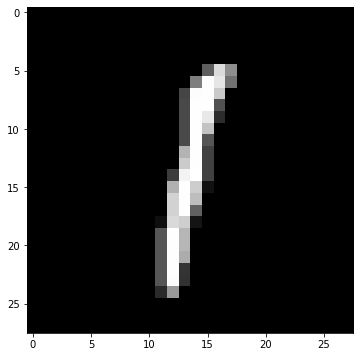

In [14]:
image = np.squeeze(np.transpose(images[0], (1, 2, 0)))
print(image.shape)

plt.figure(figsize=[6, 6])
plt.imshow(image, cmap='gray', vmin=0., vmax=1.)
plt.show()

In [18]:
attack = foolbox.attacks.FGSM(
    fmodel,
    criterion=foolbox.criteria.Misclassification()
)
adversarials = attack(images, labels, max_epsilon=0.15)
print(adversarials.shape)
print(np.mean(fmodel.forward(adversarials).argmax(axis=-1) == labels))

(64, 1, 28, 28)
0.046875


(28, 28)
(28, 28)
0.10710001 -0.10710001
(28, 28)


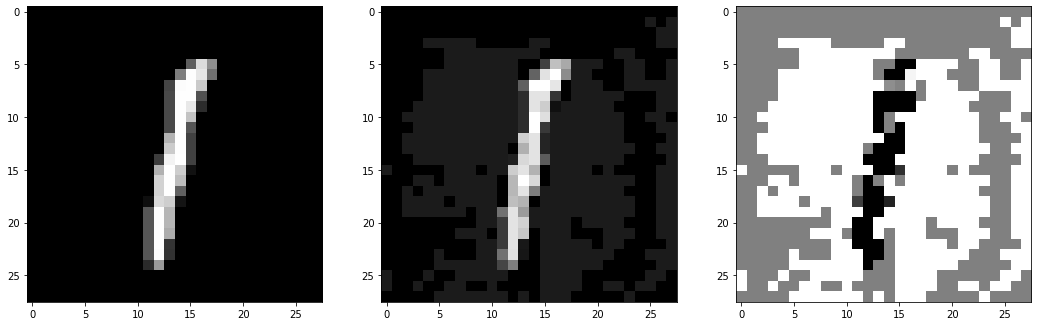

In [19]:
image = np.squeeze(np.transpose(images[0], (1, 2, 0)))
print(image.shape)
# ad = np.transpose(adversarials[0].perturbed, (1, 2, 0))
ad = np.squeeze(np.transpose(adversarials[0], (1, 2, 0)))
print(ad.shape)

p = ad - image
imax = np.max(p)
imin = np.min(p)
print(imax, imin)
p = (p - imin)/ (imax-imin)
print(p.shape)

plt.figure(figsize=[18, 6])
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0., vmax=1.)
plt.subplot(1, 3, 2)
plt.imshow(ad, cmap='gray', vmin=0., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(p, cmap='gray', vmin=0., vmax=1.)
plt.show()

In [20]:
ad_tensor = torch.tensor(adversarials, dtype=torch.float32)
print(ad_tensor.size())
ad_tensor = ad_tensor.to(device)
ad_out = model(ad_tensor)
print(ad_out.shape)
preds = ad_out.max(1, keepdim=True)[1]

for i, p in enumerate(preds, 0):
    if p.item() != y[i]:
        print(f'[{i:2d}] pred={p.item()} label={y[i]}')
    

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])
[ 0] pred=8 label=6
[ 1] pred=1 label=2
[ 2] pred=1 label=3
[ 3] pred=1 label=4
[ 4] pred=9 label=8
[ 5] pred=9 label=3
[ 6] pred=1 label=6
[ 7] pred=3 label=1
[ 8] pred=1 label=2
[ 9] pred=1 label=2
[10] pred=1 label=6
[11] pred=1 label=9
[12] pred=9 label=4
[13] pred=1 label=0
[15] pred=1 label=2
[16] pred=1 label=6
[17] pred=9 label=7
[18] pred=1 label=8
[20] pred=1 label=4
[21] pred=1 label=5
[22] pred=1 label=8
[24] pred=5 label=3
[25] pred=8 label=1
[26] pred=1 label=0
[28] pred=8 label=1
[29] pred=1 label=7
[30] pred=1 label=3
[34] pred=1 label=0
[35] pred=1 label=3
[36] pred=1 label=4
[37] pred=1 label=3
[38] pred=8 label=5
[39] pred=1 label=4
[41] pred=1 label=8
[42] pred=1 label=2
[43] pred=9 label=1
[45] pred=1 label=5
[46] pred=1 label=5
[47] pred=8 label=9
[48] pred=1 label=8
[49] pred=1 label=9
[50] pred=8 label=4
[51] pred=8 label=0
[52] pred=1 label=9
[54] pred=9 label=3
[55] pred=1 label=9
[56] pred=1 label=6
[58] pred=1